In [ ]:
%load_ext sql
%sql sqlite:///chinook.db

'Connected: @chinook.db'

# Транзакции в SQLite

https://www.sqlite.org/lang_transaction.html

https://www.sqlite.org/atomiccommit.html

https://sqliteonline.com - можно попробовать здесь вместо jupyter

## BEGIN

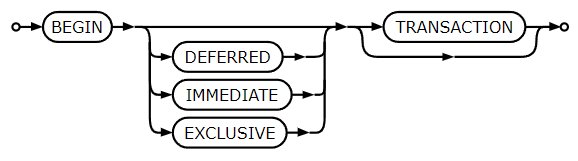

Есть три режима блокировки: DEFERRED, IMMEDIATE, EXCLUSIVE. 

DEFERRED – режим по умолчанию в SQLite. База данных блокируется на запись при выполнении первого оператора чтения или записи, который находится внутри тела транзакции после команды BEGIN.

IMMEDIATE – блокировка базы данных, как только будет выполнена команда BEGIN. При этом режим IMMEDIATE в SQLIte допускает, что другие транзакции могут читать данные из базы данных, но не записывать. 

EXCLUSIVE – самый высокий уровень блокировки базы данных в SQLite. Режим EXCLUSIVE блокирует базу данных при выполнении команды BEGIN и при этом другие транзакции не могут ни читать данные из базы данных, ни изменять данные.

## COMMIT

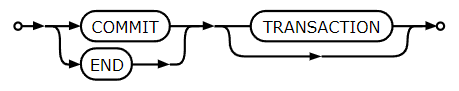

Оператор COMMIT в базах данных SQLite подтверждает изменения, внесенные транзакцией. 

```
-- Пример использования оператора COMMIT в базах данных SQLite

BEGIN;

SELECT * FROM invoice_items LIMIT 10;
 
DELETE FROM invoice_items WHERE invoiceid = 1;

SELECT * FROM invoice_items LIMIT 10;
 
-- Пока вы не выполните команду COMMIT, строки не будут удалены, так как транзакция еще не подтверждена
 
COMMIT;

SELECT * FROM invoice_items LIMIT 10;
```

##ROLLBACK

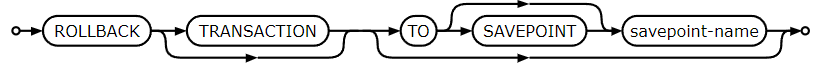

ROLLBACK TRANSACTION откатывает изменения и завершает транзакцию. Использование оператора SAVEPOINT позволяет откатить транзакцию на контрольную точку, но не завершать ее, чтобы выполнить операции повторно.

```
BEGIN;

SELECT * FROM invoice_items LIMIT 10;

DELETE FROM invoice_items WHERE invoiceid = 1;

SAVEPOINT x_point;

DELETE FROM invoice_items WHERE invoiceid = 2;

SELECT * FROM invoice_items LIMIT 10;

ROLLBACK to x_point;

RELEASE SAVEPOINT x_point;

SELECT * FROM invoice_items LIMIT 10; 
```



## Журнал 

```
PRAGMA journal_mode = DELETE | TRUNCATE | PERSIST | MEMORY | WAL | OFF;
```

https://www.sqlite.org/tempfiles.html

По умолчанию журнал ведется в режиме DELETE. Это означает, что файл журнала удаляется после завершения транзакции. Сам факт наличия файла с журналом в этом режиме означает для SQLite, что транзакция не была завершена, база нуждается в восстановлении.

*В режиме TRUNCATE файл журнала обрезается до нуля (на некоторых системах это работает быстрее, чем удаление файла).*

*В режиме PERSIST начало файла журнала забивается нулями (при этом его размер не меняется и он может занимать кучу места).*

В режиме MEMORY файл журнала ведется только в оперативной памяти, и это работает быстро, но не гарантирует восстановление базы при сбоях.

PRAGMA journal_mode = OFF: отключение журнала

Есть поддержка WAL https://www.sqlite.org/wal.html

PRAGMA synchronous задает степень гарантии сохранения данных.

При режиме OFF SQLite считает, что данные фиксированы на диске сразу после того как он передал их операционной системе. Это означает, что целостность гарантирована при аварии приложения (поскольку ОС продолжает работать), но не при аварии ОС или отключении питания.

Режим синхронизации NORMAL гарантирует целостность при авариях ОС и почти при всех отключениях питания. Это некий средний, компромиссный режим по производительности и надежности.

Режим FULL гарантирует целостность всегда и везде и при любых авариях. Но работает медленнее, поскольку в определенных местах делаются паузы ожидания. Стоит по умолчанию.

# Задание:

1) Добавить (insert) сегодняшний заказ от клиента Petr Ivanov (address@ mail.ru) композиции Michael Jackson - Billie Jean (2 штуки)

In [ ]:
%%sql 
SELECT date('now') -- сегодня

 * sqlite:///chinook.db
Done.


date('now') -- сегодня
2022-04-26


In [ ]:
%%sql

insert into customers (customerid, firstname, lastname, email) values
((select COALESCE(MAX(customerid)+1,1) from customers)
  ,'Petr'
  ,'Ivanov'
  ,'address@mail.ru'
);

insert into invoices (invoiceid, customerid, invoicedate, total) values
(
   (select COALESCE(MAX(invoiceid)+1,1) from invoices)
  ,(select customerid from customers WHERE firstname = 'Petr' 
                                       AND lastname  = 'Ivanov')
	,(SELECT date('now'))
  ,(2*(SELECT unitprice from tracks WHERE name = 'Billie Jean')) 
);

insert into invoice_items (invoicelineid, invoiceid, trackid, unitprice, quantity) values
(
   (select COALESCE(MAX(invoicelineid)+1,1) from invoice_items)
  ,(SELECT invoiceid FROM invoices WHERE customerid in 
    (select customerid from customers WHERE firstname = 'Petr' 
    								                    AND lastname  = 'Ivanov'))
  ,(SELECT trackid from tracks WHERE name = 'Billie Jean')
  ,(SELECT unitprice from tracks WHERE trackid    
    in (SELECT trackid from tracks WHERE name = 'Billie Jean'))
	,(2)
);

2) Удалить (delete) жанр блюз целиком

In [ ]:
%%sql
DELETE FROM invoice_items WHERE trackid in 
(
  SELECT trackid FROM tracks
  INNER JOIN genres g USING (genreid)
  WHERE g.Name = 'Blues'
);
DELETE FROM playlists WHERE playlistid IN
(
   SELECT playlistid FROM playlist_track WHERE trackid in (
   SELECT trackid FROM tracks
   INNER JOIN genres g USING(genreid)   WHERE g.Name = 'Blues')
);
DELETE FROM playlist_track WHERE trackid in 
(
  SELECT trackid FROM tracks
  INNER JOIN genres g USING (genreid)
  WHERE g.Name = 'Blues'
);
DELETE FROM artists WHERE artistid in
(
  SELECT artistid FROM albums 
  				  WHERE albumid in (
   SELECT albumid FROM tracks INNER join genres USING(genreid) 
    			  WHERE genres.Name = 'Blues') 
);
DELETE FROM albums WHERE albumid in
(
   SELECT albumid FROM tracks INNER join genres USING(genreid) 
    			  WHERE genres.Name = 'Blues'
);
DELETE FROM media_types WHERE mediatypeid in 
(
  SELECT mediatypeid FROM tracks INNER join genres USING(genreid) 
    			  WHERE genres.Name = 'Blues'
);
DELETE FROM tracks WHERE trackid in 
( 
  SELECT trackid FROM tracks 
  INNER join genres USING(genreid) 
  WHERE genres.Name = 'Blues'
);
DELETE FROM genres WHERE name = 'Blues'

3) Увеличить (update) цены в 2 раза на треки, которые покупал Leonie Köhler

In [ ]:
%%sql
UPDATE tracks 
SET unitprice = 2*unitprice
WHERE trackid in 
( 
  SELECT trackid FROM invoice_items WHERE invoicelineid in 
  (
    SELECT invoicelineid FROM invoices WHERE invoiceid in 
    (
      SELECT customerid FROM customers WHERE firstname = 'Leonie' and lastname = 'Köhler'
     )
   )
 );

 UPDATE invoice_items 
SET unitprice = 2*unitprice
WHERE invoicelineid in 
( 
    SELECT invoicelineid FROM invoices WHERE invoiceid in 
    (
      SELECT customerid FROM customers WHERE firstname = 'Leonie' and lastname = 'Köhler'
     )
 );